# Agent Architecture
ReAct -> General Agent Architecture
- Act -> tool call
- Observe -> passes tools output back to model
- Reason -> bases on output response from tool model will decide what to do in next step

In [41]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage,HumanMessage
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from langgraph.graph.message import add_messages
load_dotenv()

True

In [42]:
import os

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY']=os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_PROJECT']="ReAct Agent"


In [43]:
# message state
class state(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [44]:
llm=ChatGroq(model='llama-3.1-8b-instant')

In [45]:
# lets create tools

def add_tool(a:int,b:int)->int:
    '''add a and b
    Args:
    a(int): first number
    b(int):second number
    return a+b(int) '''
    return a+b

def multiply_tool(a:int,b:int)->int:
    '''multiply a and b
    Args:
    a(int): first number
    b(int):second number
    return a*b(int) '''
    return a*b

def subtract_tool(a:int,b:int)->int:
    '''subtract a and b
    Args:
    a(int): first number
    b(int):second number
    return a-b(int) '''
    return a-b

In [46]:
# langcahin built in tools
# wikipedia tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wiki_wrapper=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [47]:
# arxiv tool
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun
arxiv_wrapper=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

In [48]:
tools=[add_tool,multiply_tool,subtract_tool,wikipedia,arxiv]

In [49]:
llm_with_tool=llm.bind_tools(tools)

In [50]:
def llm_tool(state:state)->state:
    res=llm_with_tool.invoke(state['messages'])
    return {
        'messages':[res]
    }

In [51]:
from langgraph.prebuilt import ToolNode,tools_condition

In [52]:
# graph

graph=StateGraph(state)
graph.add_node('chatbot',llm_tool)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,'chatbot')
graph.add_conditional_edges('chatbot',
                            tools_condition) # if chatbot return tool call it will route to tool else END

graph.add_edge('tools','chatbot')

workflow=graph.compile()

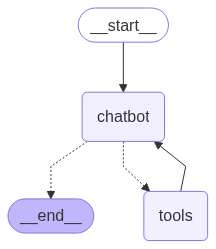

In [53]:
workflow

In [54]:
result=workflow.invoke({
    'messages':'add 5 + 2 and than multiply by 2 what will be answer?'
})

In [55]:
result

{'messages': [HumanMessage(content='add 5 + 2 and than multiply by 2 what will be answer?', additional_kwargs={}, response_metadata={}, id='5b264578-5e39-4e96-bbf4-833698a3f34d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '855a147g8', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add_tool'}, 'type': 'function'}, {'id': 'd022s1e93', 'function': {'arguments': '{"a":7,"b":2}', 'name': 'multiply_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 732, 'total_tokens': 770, 'completion_time': 0.047544474, 'prompt_time': 0.065797332, 'queue_time': 0.045397638, 'total_time': 0.113341806}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5cc30141-f1cd-41f6-a67b-9cfa8885b49f-0', tool_calls=[{'name': 'add_tool', 'args': {'a': 5, 'b': 2}, 'id': '855a147g8', 'type': 'tool_call'}, {'name': 'multiply_to

In [56]:
# result=workflow.invoke({
#     'messages':'add 50000000000000000+99999999999999999999999999999 and than multiply by 2 what will be answer?'
# })

In [57]:
result

{'messages': [HumanMessage(content='add 5 + 2 and than multiply by 2 what will be answer?', additional_kwargs={}, response_metadata={}, id='5b264578-5e39-4e96-bbf4-833698a3f34d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '855a147g8', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add_tool'}, 'type': 'function'}, {'id': 'd022s1e93', 'function': {'arguments': '{"a":7,"b":2}', 'name': 'multiply_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 732, 'total_tokens': 770, 'completion_time': 0.047544474, 'prompt_time': 0.065797332, 'queue_time': 0.045397638, 'total_time': 0.113341806}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5cc30141-f1cd-41f6-a67b-9cfa8885b49f-0', tool_calls=[{'name': 'add_tool', 'args': {'a': 5, 'b': 2}, 'id': '855a147g8', 'type': 'tool_call'}, {'name': 'multiply_to

# Agent Memory

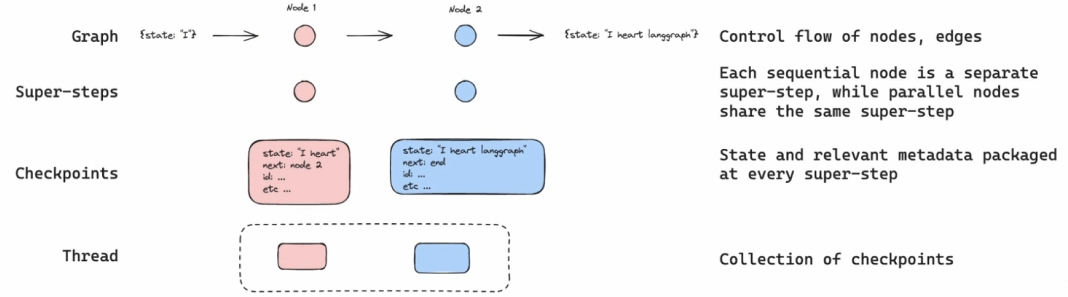

In [58]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer=MemorySaver()
workflow_m=graph.compile(checkpointer=checkpointer)

In [59]:
config={
    'configurable':{
        'thread_id':'1'
    }
}

In [60]:
result=workflow_m.invoke(
    {
        'messages':"my name is talha"
    },
    config=config
)

In [61]:
result

{'messages': [HumanMessage(content='my name is talha', additional_kwargs={}, response_metadata={}, id='8d535be4-a509-4987-aca3-bc0a5cc3d6d1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rk5vxw5xz', 'function': {'arguments': '{"query":"Talha"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 720, 'total_tokens': 736, 'completion_time': 0.021204192, 'prompt_time': 0.057587311, 'queue_time': 0.064525509, 'total_time': 0.078791503}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7083106d2c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--15b3347b-dd03-4d02-be34-3da97c8263ea-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Talha'}, 'id': 'rk5vxw5xz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 720, 'output_tokens': 16, 'total_tokens': 736}),
  ToolMessage(content='Page: Talha (name)\nSummary: Talha or Thalha is an Arab

In [62]:
result=workflow_m.invoke(
    {
        'messages':"What is my name"
    },
    config=config
)

In [63]:
result

{'messages': [HumanMessage(content='my name is talha', additional_kwargs={}, response_metadata={}, id='8d535be4-a509-4987-aca3-bc0a5cc3d6d1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rk5vxw5xz', 'function': {'arguments': '{"query":"Talha"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 720, 'total_tokens': 736, 'completion_time': 0.021204192, 'prompt_time': 0.057587311, 'queue_time': 0.064525509, 'total_time': 0.078791503}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7083106d2c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--15b3347b-dd03-4d02-be34-3da97c8263ea-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Talha'}, 'id': 'rk5vxw5xz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 720, 'output_tokens': 16, 'total_tokens': 736}),
  ToolMessage(content='Page: Talha (name)\nSummary: Talha or Thalha is an Arab